Для оптимизации производственных расходов, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

### Содержание
### [1. Подготовка данных](#section_id1)
### [2. Предобработка данных и исследовательский анализ данных](#section_id2)
### [3. Обучение модели](#section_id3)
####    [3.1. Градиентный бустинг CatBoost](#section_id4)
####   [3.2. Случайный лес](#section_id5)
####    [3.3. Градиентный бустинг LightGBM](#section_id6)
### [3. Вывод](#section_id7)

<a id='section_id1'></a>

# 1. Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#библиотека sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

#библиотеки градиентного бустинга
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
#задаем некоторые опции библиотеки pandas
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 90)

In [3]:
#функция для анализа данных
def analysis(df):
    print('DATAFRAME')
    print(df.head())
    print('CORRELATION')
    print(df.corr())
    print('DESCRIBE')
    print(df.describe())
    print('INFO')
    print(df.info())
    
#функция для создания словаря финальных результатов   
def keys_tot_last(df, col_1, col_2):
    key = 1
    keys = {}
    for i in range(len(df)):
        if df.loc[i, col_1] == key:
            print(end='')
        else:
            keys[df.loc[(i-1), col_1]] = df.loc[(i-1), col_2]
            key += 1
        if i == (len(df) - 1): 
            keys[df.loc[i, col_1]] = df.loc[(i), col_2]
            
    return keys

#функция для создания словаря первых результатов
def keys_tot_first(df, col_1, col_2):
    key = 1
    keys = {}
    for i in range(len(df)):
        if i == 0: 
            keys[df.loc[i, col_1]] = df.loc[(i), col_2]
        if df.loc[i, col_1] == key:
            print(end='')
        else:
            keys[df.loc[(i), col_1]] = df.loc[(i), col_2]
            key += 1
    return keys

#функция для строк в единственном числе
def del_one_val(df, col_1): #col_1 - key
    #создаем копию
    df_copy = df.copy()
    df_copy = df.dropna().reset_index().drop(['index'], axis = 1).copy()
    
    #создаем массив значений
    val = df_copy[col_1].value_counts().values
    
    index = []
    
    #записываем номера индексов, у которых значение равно единице
    for i in range(len(df_copy[col_1].value_counts())):
        if val[i] == 1:
            index.append(df_copy[col_1].value_counts().index[i])
    
    #удаляем строки с единичным кол-вом
    for i in range(len(index)):
        df_copy = df_copy.drop(df_copy.loc[df_copy[col_1] == index[i], col_1].index)
        
    df_copy = df_copy.reset_index().drop(['index'], axis=1)
    
    return df_copy

#отображение лучших гиперпараметров
def show(string, best_result, best_depth, best_estimators):
    print('Модель ' + string + ':')
    print()
    print('MAE =', best_result)
    print('Глубина depth =', best_depth)
    print('n_estimators =', best_estimators)

In [4]:
try:
    df_arc = pd.read_csv('E:\\DS\\final test\\final_steel\\data_arc.csv')
    df_bulk = pd.read_csv('E:\\DS\\final test\\final_steel\\data_bulk.csv')
    df_bulk_time = pd.read_csv('E:\\DS\\final test\\final_steel\\data_bulk_time.csv')
    df_gas = pd.read_csv('E:\\DS\\final test\\final_steel\\data_gas.csv')
    df_temp = pd.read_csv('E:\\DS\\final test\\final_steel\\data_temp.csv')
    df_wire = pd.read_csv('E:\\DS\\final test\\final_steel\\data_wire.csv')
    df_wire_time = pd.read_csv('E:\\DS\\final test\\final_steel\\data_wire_time.csv')
    print('1')
except:
    df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
    print('2')

2


In [5]:
analysis(df_arc)

DATAFRAME
   key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  Реактивная мощность
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059             0.687084
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607             0.520285
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363             0.498805
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363             1.062669
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755             0.414397
CORRELATION
                          key  Активная мощность  Реактивная мощность
key                  1.000000          -0.021382            -0.004396
Активная мощность   -0.021382           1.000000             0.054437
Реактивная мощность -0.004396           0.054437             1.000000
DESCRIBE
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.670

Видим, что все значения уникальные. В столбце реактивная мощность мин значение отрицательное. Удалим данную строку

In [6]:
df_arc = df_arc.drop(df_arc.loc[(df_arc['Реактивная мощность']<0)].index)
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.670453,0.500723
std,934.593897,0.408170,0.310880
min,1.000000,0.030002,0.020806
25%,806.000000,0.395295,0.291003
50%,1617.000000,0.555565,0.415984
75%,2429.000000,0.857049,0.637403
max,3241.000000,3.731596,2.676388


Очень высокая корреляция наблюдается между активной и реактивной мощностями. В связи с этим возникает мультиколлинеарность, поэтому можем удалить один из двух столбцов

In [7]:
analysis(df_bulk)

DATAFRAME
   key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  Bulk 9  Bulk 10  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN     NaN      NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN     NaN      NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN     NaN      NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN     NaN      NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN     NaN      NaN   

   Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0      NaN    206.0      NaN    150.0    154.0  
1      NaN    206.0      NaN    149.0    154.0  
2      NaN    205.0      NaN    152.0    153.0  
3      NaN    207.0      NaN    153.0    154.0  
4      NaN    203.0      NaN    151.0    152.0  
CORRELATION
              key    Bulk 1    Bulk 2    Bulk 3    Bulk 4    Bulk 5    Bulk 6    Bulk 7  \
key      1.000000 -0.192066 -0.038643 -0.08033

Сильной корреляции между признаками не наблюдается, вследствие чего оставим все как есть. Насчет пропусков, заменим их просто нулями, полагая, что на данном этапе данной итерации подача сыпучих материалов не наблюдалась

Некоторые признаки имеют диапазон ненулевых значений от 1 до 30. Попробуем их для начала удалить и обучить модель. В случае чего вернем их обратно.

In [8]:
analysis(df_bulk_time)

DATAFRAME
   key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8 Bulk 9  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:48:43    NaN    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:18:50    NaN    NaN    NaN    NaN    NaN   

  Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14              Bulk 15  
0     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52  2019-05-03 11:03:52  
1     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20  2019-05-03 11:40:20  
2     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40  2019-05-03 12:09:40  
3     NaN     NaN  2019-05-03 12:41:24     NaN  2019-05-03 12:41:24  2019-05-03 12:41:24  
4     NaN   

Как можно предположить на первый взгляд, ячейки в df_bulk и df_bulk_time совпадают. Значит это скорее всего не случайные пропуски, а просто видимо так подают сыпучие материалы.

In [9]:
analysis(df_gas)

DATAFRAME
   key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692
CORRELATION
            key     Газ 1
key    1.000000 -0.040655
Газ 1 -0.040655  1.000000
DESCRIBE
               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040
INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None


По корреляции вопросов нет. Пропусков тут тоже нет

In [10]:
analysis(df_temp)

DATAFRAME
   key         Время замера  Температура
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0
2    1  2019-05-03 11:29:11       1618.0
3    1  2019-05-03 11:30:01       1601.0
4    1  2019-05-03 11:30:39       1613.0
CORRELATION
                  key  Температура
key          1.000000    -0.046895
Температура -0.046895     1.000000
DESCRIBE
                key   Температура
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241.000000   1705.000000
INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None


А вот и целевой признак, который мы должны будем предсказывать. Пропуски можем заменить медианой (после разделения на обучающую и тестовую выборки)

In [11]:
analysis(df_wire)

DATAFRAME
   key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  Wire 9
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN     NaN
CORRELATION
             key    Wire 1    Wire 2    Wire 3    Wire 4  Wire 5    Wire 6    Wire 7  \
key     1.000000 -0.083352 -0.005461 -0.084460  0.389064     NaN  0.082274  0.578898   
Wire 1 -0.083352  1.000000 -0.030892  0.724370  0.054001     NaN -0.280807 -0.035072   
Wire 2 -0.005461 -0.030892  1.000000 -0.081852       NaN     NaN -0.265706       NaN   
Wire 3 -0.084460  0.724370 -0.081852  1.000000  0.069854     NaN -0.221602 -0.056948   
Wire 4  0.389064  0.054001       NaN  0.

Имеется корреляция между Wire 3 и Wire 1, но она не такая большая

In [12]:
analysis(df_wire_time)

DATAFRAME
   key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6 Wire 7  \
0    1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN    NaN    NaN   

  Wire 8 Wire 9  
0    NaN    NaN  
1    NaN    NaN  
2    NaN    NaN  
3    NaN    NaN  
4    NaN    NaN  
CORRELATION
     key
key  1.0
DESCRIBE
               key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000
INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1 

Тут также будут пропуски в тех же ячейках что и в датасете df_wire

<a id='section_id2'></a>

# 2. Предобработка данных и исследовательский анализ данных

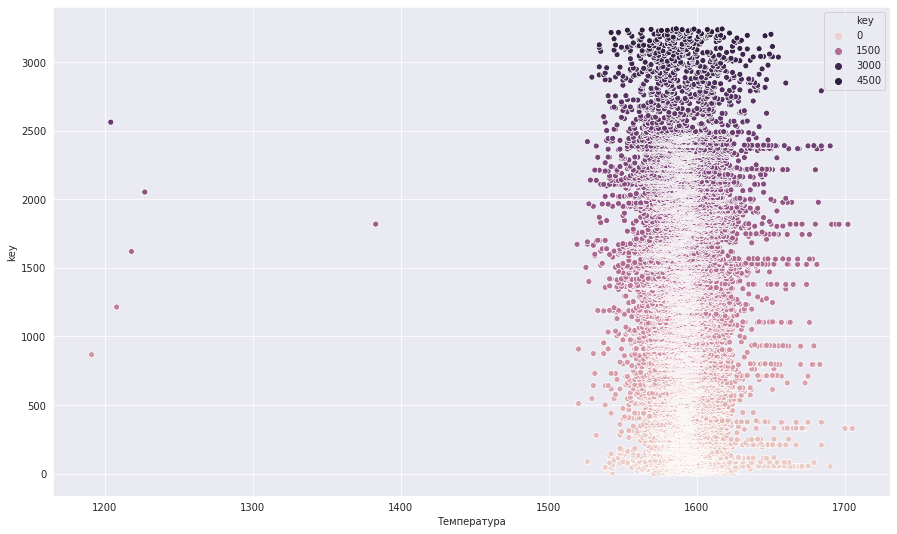

In [13]:
plt.figure(figsize=(15,9))
sns.set_style('darkgrid')
sns.scatterplot(x = 'Температура', y = 'key', data = df_temp, hue = 'key')

По графику видно, что в среднем температура на разных этапах держится в районе от 1500 до 1700 (Кельвин или Градус Цельсия). Изредка есть что на разных итерациях температура падает до 1200 единиц.

In [14]:
df_bulk_sum = df_bulk.merge(df_bulk_time, on = 'key')
df_bulk_sum

,key,Bulk 1_x,Bulk 2_x,Bulk 3_x,Bulk 4_x,Bulk 5_x,Bulk 6_x,Bulk 7_x,Bulk 8_x,Bulk 9_x,Bulk 10_x,Bulk 11_x,Bulk 12_x,Bulk 13_x,Bulk 14_x,Bulk 15_x,Bulk 1_y,Bulk 2_y,Bulk 3_y,Bulk 4_y,Bulk 5_y,Bulk 6_y,Bulk 7_y,Bulk 8_y,Bulk 9_y,Bulk 10_y,Bulk 11_y,Bulk 12_y,Bulk 13_y,Bulk 14_y,Bulk 15_y
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


In [15]:
df_wire_sum = df_wire.merge(df_wire_time, on = 'key')
df_wire_sum

,key,Wire 1_x,Wire 2_x,Wire 3_x,Wire 4_x,Wire 5_x,Wire 6_x,Wire 7_x,Wire 8_x,Wire 9_x,Wire 1_y,Wire 2_y,Wire 3_y,Wire 4_y,Wire 5_y,Wire 6_y,Wire 7_y,Wire 8_y,Wire 9_y
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_sum_1 = df_bulk_sum.merge(df_wire_sum, on = 'key', how = 'outer')
df_sum_1

,key,Bulk 1_x,Bulk 2_x,Bulk 3_x,Bulk 4_x,Bulk 5_x,Bulk 6_x,Bulk 7_x,Bulk 8_x,Bulk 9_x,Bulk 10_x,Bulk 11_x,Bulk 12_x,Bulk 13_x,Bulk 14_x,Bulk 15_x,Bulk 1_y,Bulk 2_y,Bulk 3_y,Bulk 4_y,Bulk 5_y,Bulk 6_y,Bulk 7_y,Bulk 8_y,Bulk 9_y,Bulk 10_y,Bulk 11_y,Bulk 12_y,Bulk 13_y,Bulk 14_y,Bulk 15_y,Wire 1_x,Wire 2_x,Wire 3_x,Wire 4_x,Wire 5_x,Wire 6_x,Wire 7_x,Wire 8_x,Wire 9_x,Wire 1_y,Wire 2_y,Wire 3_y,Wire 4_y,Wire 5_y,Wire 6_y,Wire 7_y,Wire 8_y,Wire 9_y
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3180,3018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.109917,9.138480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-24 21:59:04,2019-08-24 21:59:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3181,3026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.109917,25.032799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-25 04:04:40,2019-08-25 04:05:18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3182,3047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.049120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-25 21:07:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3183,3182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.406395,9.108320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-30 06:11:41,2019-08-30 06:27:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_temp_copy = del_one_val(df_temp, 'key')

In [18]:
df_temp_copy['key'].value_counts()

1513    16
44      16
46      16
1214    16
1689    15
        ..
951      2
1415     2
1381     2
1713     2
2194     2
Name: key, Length: 2475, dtype: int64

In [19]:
#выделяем последние температуры
temp_last = keys_tot_last(df_temp_copy, 'key', 'Температура')

In [20]:
#создание таргета
df_temp_final = pd.DataFrame(temp_last.values(), index = temp_last.keys()).reset_index()
df_temp_final.columns = ['key', 'Температура_1']
df_temp_final

,key,Температура_1
0,1,1613.0
1,2,1602.0
2,3,1599.0
3,4,1625.0
4,5,1602.0
...,...,...
2470,2495,1591.0
2471,2496,1591.0
2472,2497,1589.0
2473,2498,1594.0


In [21]:
#выделяем первые температуры и используем ее как признак feature
temp_first = keys_tot_first(df_temp_copy, 'key', 'Температура')

In [22]:
#создание признак feature
df_temp_final_first = pd.DataFrame(temp_first.values(), index = temp_first.keys()).reset_index()
df_temp_final_first.columns = ['key', 'Температура_2']
df_temp_final_first

,key,Температура_2
0,1,1571.0
1,2,1581.0
2,3,1596.0
3,4,1601.0
4,5,1576.0
...,...,...
2470,2495,1570.0
2471,2496,1554.0
2472,2497,1571.0
2473,2498,1591.0


No handles with labels found to put in legend.


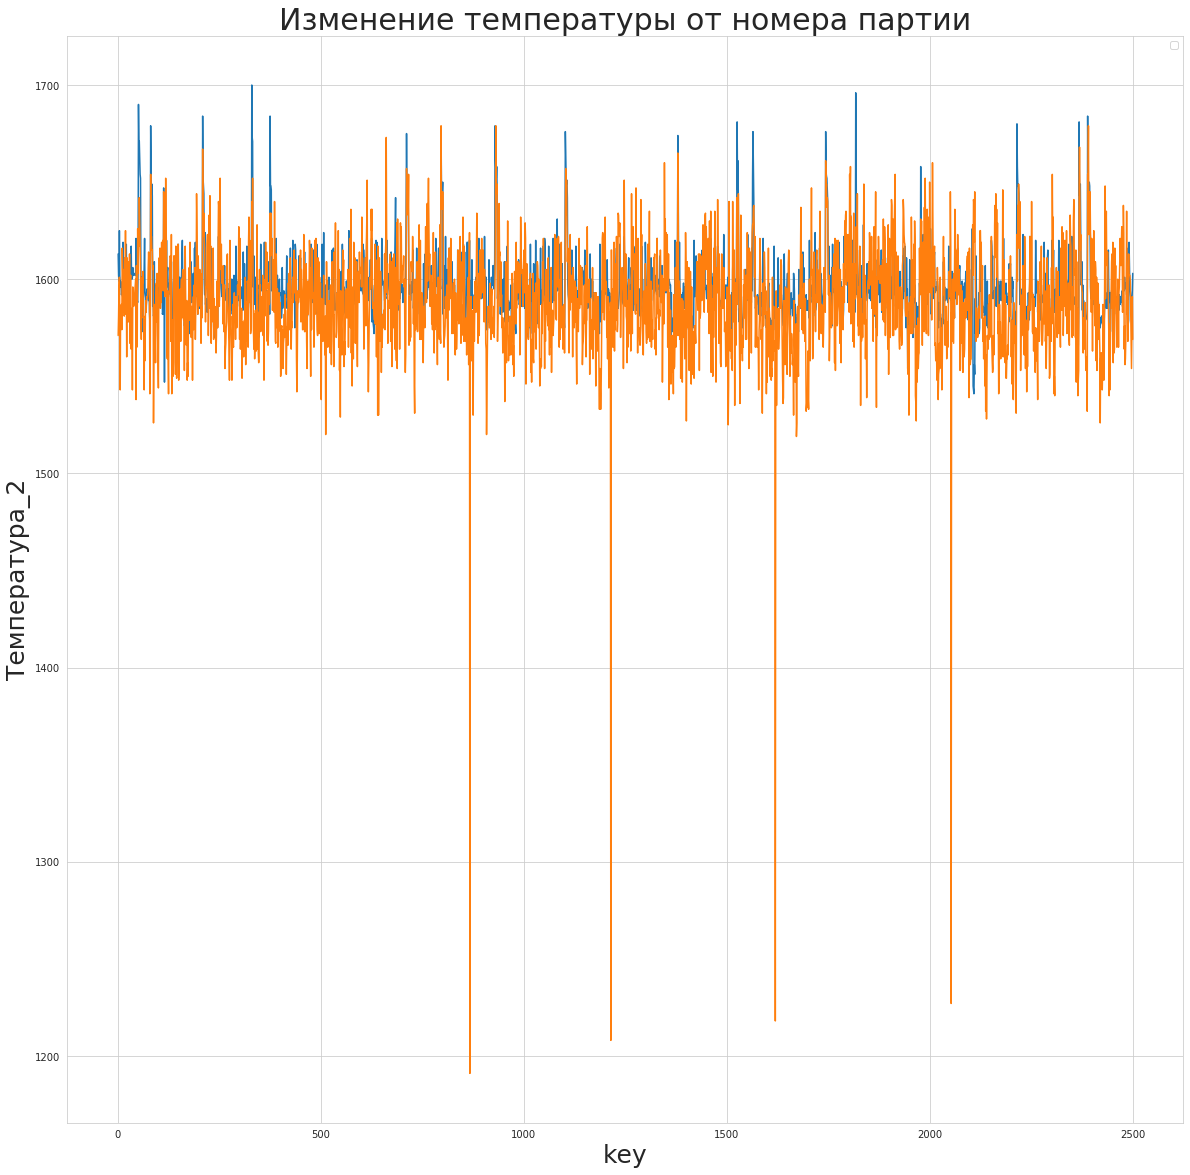

In [23]:
sns.set_style('whitegrid')
plt.figure(figsize=(20,20))
plt.title('Изменение температуры от номера партии', fontsize=30 )
plt.xlabel('Номер партии', fontsize=25)
plt.ylabel('Температура', fontsize=25)
plt.legend()
sns.lineplot(x = 'key', y = 'Температура_1', data = df_temp_final)
sns.lineplot(x = 'key', y = 'Температура_2', data = df_temp_final_first)

Диапазон конечных температур варьируется от 1540 до 1700 градусов Цельсия, что соответствует температуре плавления стали, начальных от 1200 градусов до 1650. Температура плавления стали где-то в районе 1500 градусов Цельсия.

In [24]:
#добавляем таблицу с газом в общую
df_sum_2 = df_sum_1.merge(df_gas, on = 'key', how = 'outer')
df_sum_2.head()

,key,Bulk 1_x,Bulk 2_x,Bulk 3_x,Bulk 4_x,Bulk 5_x,Bulk 6_x,Bulk 7_x,Bulk 8_x,Bulk 9_x,Bulk 10_x,Bulk 11_x,Bulk 12_x,Bulk 13_x,Bulk 14_x,Bulk 15_x,Bulk 1_y,Bulk 2_y,Bulk 3_y,Bulk 4_y,Bulk 5_y,Bulk 6_y,Bulk 7_y,Bulk 8_y,Bulk 9_y,Bulk 10_y,Bulk 11_y,Bulk 12_y,Bulk 13_y,Bulk 14_y,Bulk 15_y,Wire 1_x,Wire 2_x,Wire 3_x,Wire 4_x,Wire 5_x,Wire 6_x,Wire 7_x,Wire 8_x,Wire 9_x,Wire 1_y,Wire 2_y,Wire 3_y,Wire 4_y,Wire 5_y,Wire 6_y,Wire 7_y,Wire 8_y,Wire 9_y,Газ 1
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.749986
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.555561
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.554793
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.841219
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.413692


In [25]:
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


У признаков Активная мощность и реактивная мощность сильная корреляция, поэтому один из признаков мы просто исключим, либо просто найдем полную мощность.

Найдем полную мощность по партиям и длительность в секундах

In [26]:
df_arc['key'].value_counts(ascending = True).head()

246    1
732    1
556    1
248    1
977    1
Name: key, dtype: int64

In [27]:
df_arc_copy = del_one_val(df_arc, 'key')

In [28]:
df_arc_copy['key'].value_counts()

2108    16
1513    15
1689    15
2567    14
322     13
        ..
2456     2
1708     2
2940     2
1746     2
3195     2
Name: key, Length: 3175, dtype: int64

In [29]:
#найдем полную мощность
df_arc_copy['fullpower'] = np.sqrt(df_arc_copy['Активная мощность'] ** 2 + df_arc_copy['Реактивная мощность'] ** 2)
df_arc_copy

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,fullpower
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239
...,...,...,...,...,...,...
14831,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0.640648
14832,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0.855559
14833,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0.874560
14834,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0.264489


In [30]:
#найдем суммарные мощности по партиям
df_fullpower = df_arc_copy.pivot_table(index = 'key', values = 'fullpower', aggfunc='sum')
df_fullpower = df_fullpower.reset_index()
df_fullpower

,key,fullpower
0,1,5.826395
1,2,3.649216
2,3,2.989534
3,4,3.814962
4,5,4.035758
...,...,...
3170,3237,4.844982
3171,3238,2.696542
3172,3239,5.611883
3173,3240,3.891856


In [31]:
#посчитаем длительности нагревания на каждой итерации партии, а потом найдем суммарную длительность нагревания по каждой партии
df_arc_copy['Начало нагрева дугой'] = pd.to_datetime(df_arc_copy['Начало нагрева дугой'])
df_arc_copy['Конец нагрева дугой'] = pd.to_datetime(df_arc_copy['Конец нагрева дугой'])
df_arc_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14836 entries, 0 to 14835
Data columns (total 6 columns):
key                     14836 non-null int64
Начало нагрева дугой    14836 non-null datetime64[ns]
Конец нагрева дугой     14836 non-null datetime64[ns]
Активная мощность       14836 non-null float64
Реактивная мощность     14836 non-null float64
fullpower               14836 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 695.6 KB


In [32]:
df_arc_copy['Длительность'] = (df_arc_copy['Конец нагрева дугой'].dt.hour * 3600 + df_arc_copy['Конец нагрева дугой'].dt.minute * 60 + df_arc_copy['Конец нагрева дугой'].dt.second) - \
(df_arc_copy['Начало нагрева дугой'].dt.hour * 3600 + df_arc_copy['Начало нагрева дугой'].dt.minute * 60 + df_arc_copy['Начало нагрева дугой'].dt.second)
df_arc_copy

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,fullpower,Длительность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148
...,...,...,...,...,...,...,...
14831,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0.640648,157
14832,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0.855559,180
14833,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0.874560,184
14834,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0.264489,57


In [33]:
#в случае перехода на другой день
df_arc_copy.loc[df_arc_copy['Длительность']<0, 'Длительность'] += 86400
df_arc_copy.describe()

,key,Активная мощность,Реактивная мощность,fullpower,Длительность
count,14836.000000,14836.000000,14836.000000,14836.000000,14836.000000
mean,1615.491642,0.670902,0.501027,0.839312,171.751752
std,934.602933,0.408530,0.311165,0.510307,98.280995
min,1.000000,0.030002,0.020806,0.036664,11.000000
25%,806.750000,0.395222,0.290921,0.495081,107.000000
50%,1617.000000,0.555867,0.416564,0.695544,147.000000
75%,2429.000000,0.857891,0.637846,1.068043,215.000000
max,3241.000000,3.731596,2.676388,4.592152,907.000000


In [34]:
df_duration = df_arc_copy.pivot_table(index = 'key', values = 'Длительность', aggfunc='sum')
df_duration = df_duration.reset_index()
df_duration

,key,Длительность
0,1,1098
1,2,811
2,3,655
3,4,741
4,5,869
...,...,...
3170,3237,909
3171,3238,546
3172,3239,1216
3173,3240,839


In [35]:
df_count = df_arc_copy['key'].value_counts().reset_index()
df_count

,index,key
0,2108,16
1,1513,15
2,1689,15
3,2567,14
4,322,13
...,...,...
3170,2456,2
3171,1708,2
3172,2940,2
3173,1746,2


In [36]:
df_count.columns = ['key', 'value']
df_count

,key,value
0,2108,16
1,1513,15
2,1689,15
3,2567,14
4,322,13
...,...,...
3170,2456,2
3171,1708,2
3172,2940,2
3173,1746,2


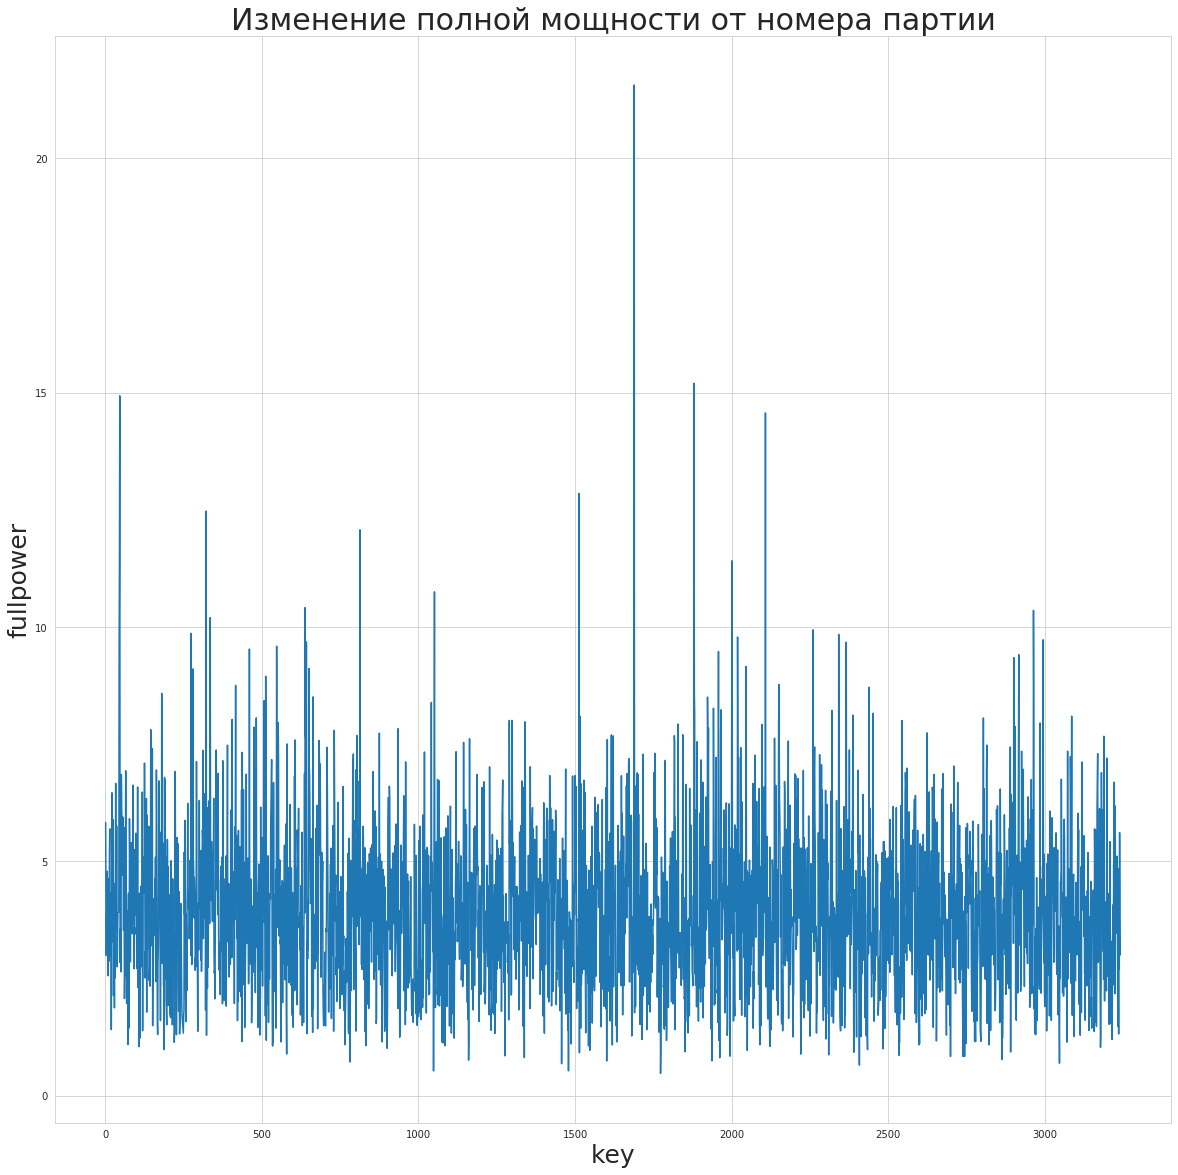

In [37]:
sns.set_style('whitegrid')
plt.figure(figsize=(20,20))
plt.title('Изменение полной мощности от номера партии', fontsize=30 )
plt.xlabel('Номер партии', fontsize=25)
plt.ylabel('Полная мощность', fontsize=25)
sns.lineplot(x = 'key', y = 'fullpower', data = df_fullpower)

Пиковая мощность приходится на 1700 партии. Там скорее всего была большая подача материалов. Судя по температуре в данный момент как раз и было понижение температуры до 1540 градусов.

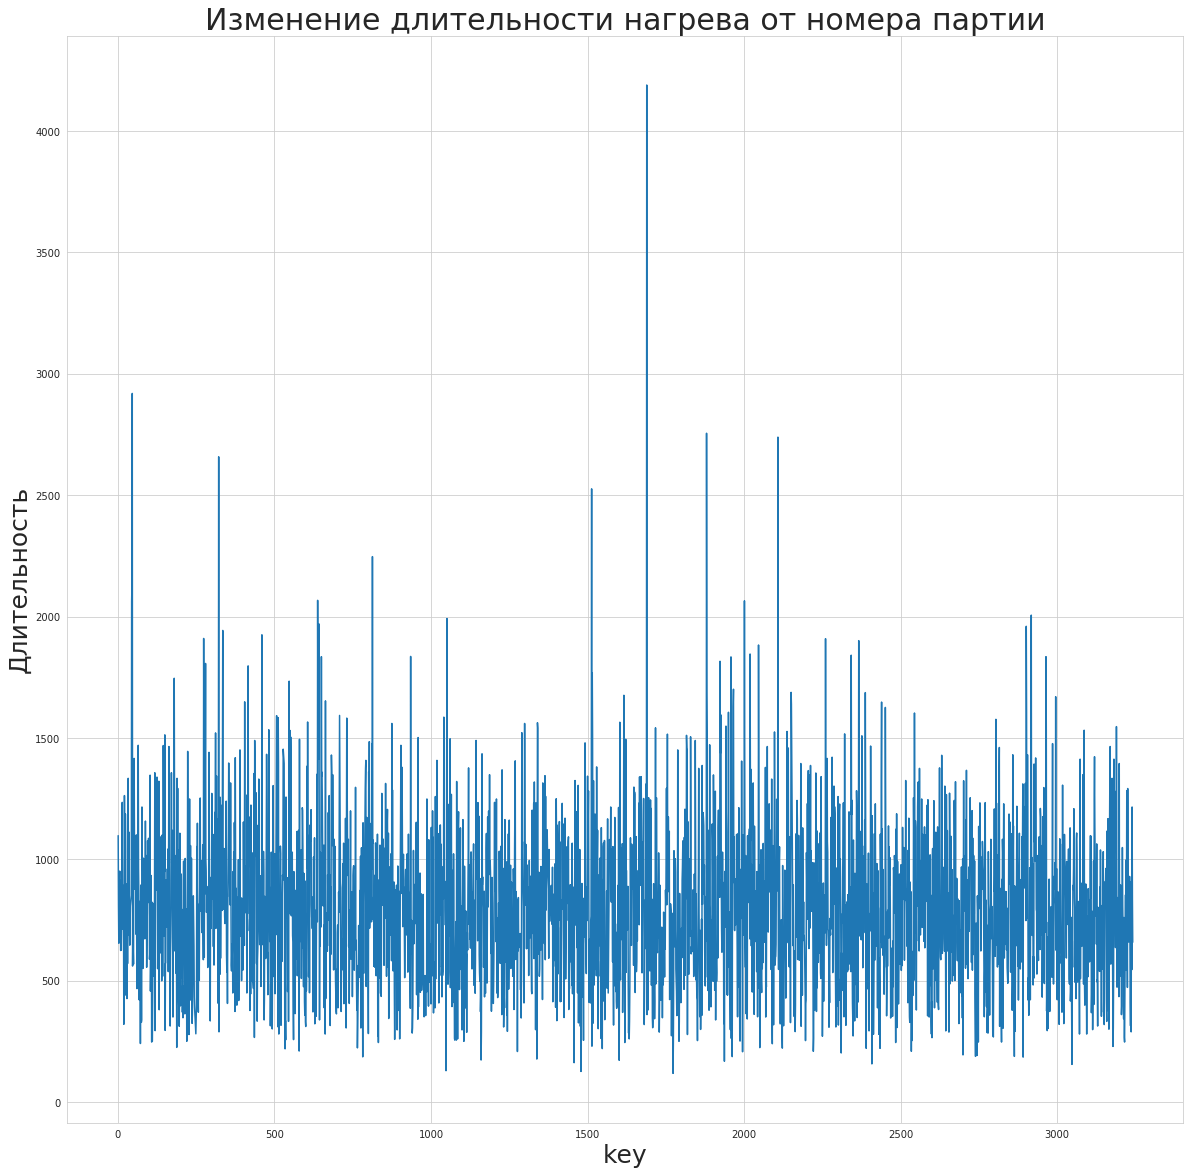

In [38]:
sns.set_style('whitegrid')
plt.figure(figsize=(20,20))
plt.title('Изменение длительности нагрева от номера партии', fontsize=30 )
plt.xlabel('Номер партии', fontsize=25)
plt.ylabel('Длительность нагрева, с', fontsize=25)
sns.lineplot(x = 'key', y = 'Длительность', data = df_duration)

Максимальная длительность нагрева происходит как раз на 1700 партию (как раз в этом же моменте максимальная мощность).

In [39]:
df_sum_3 = df_sum_2.merge(df_fullpower, on = 'key', how = 'outer')
df_sum_3

,key,Bulk 1_x,Bulk 2_x,Bulk 3_x,Bulk 4_x,Bulk 5_x,Bulk 6_x,Bulk 7_x,Bulk 8_x,Bulk 9_x,Bulk 10_x,Bulk 11_x,Bulk 12_x,Bulk 13_x,Bulk 14_x,Bulk 15_x,Bulk 1_y,Bulk 2_y,Bulk 3_y,Bulk 4_y,Bulk 5_y,Bulk 6_y,Bulk 7_y,Bulk 8_y,Bulk 9_y,Bulk 10_y,Bulk 11_y,Bulk 12_y,Bulk 13_y,Bulk 14_y,Bulk 15_y,Wire 1_x,Wire 2_x,Wire 3_x,Wire 4_x,Wire 5_x,Wire 6_x,Wire 7_x,Wire 8_x,Wire 9_x,Wire 1_y,Wire 2_y,Wire 3_y,Wire 4_y,Wire 5_y,Wire 6_y,Wire 7_y,Wire 8_y,Wire 9_y,Газ 1,fullpower
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.749986,5.826395
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.555561,3.649216
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.554793,2.989534
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.841219,3.814962
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.413692,4.035758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3236,2628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.149644,2.997830
3237,2683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.338997,NaN
3238,2863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.094691,0.768489
3239,3200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.908588,NaN


In [40]:
df_sum_4 = df_sum_3.merge(df_duration, on='key', how = 'outer')
df_sum_4

,key,Bulk 1_x,Bulk 2_x,Bulk 3_x,Bulk 4_x,Bulk 5_x,Bulk 6_x,Bulk 7_x,Bulk 8_x,Bulk 9_x,Bulk 10_x,Bulk 11_x,Bulk 12_x,Bulk 13_x,Bulk 14_x,Bulk 15_x,Bulk 1_y,Bulk 2_y,Bulk 3_y,Bulk 4_y,Bulk 5_y,Bulk 6_y,Bulk 7_y,Bulk 8_y,Bulk 9_y,Bulk 10_y,Bulk 11_y,Bulk 12_y,Bulk 13_y,Bulk 14_y,Bulk 15_y,Wire 1_x,Wire 2_x,Wire 3_x,Wire 4_x,Wire 5_x,Wire 6_x,Wire 7_x,Wire 8_x,Wire 9_x,Wire 1_y,Wire 2_y,Wire 3_y,Wire 4_y,Wire 5_y,Wire 6_y,Wire 7_y,Wire 8_y,Wire 9_y,Газ 1,fullpower,Длительность
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.749986,5.826395,1098.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.555561,3.649216,811.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.554793,2.989534,655.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.841219,3.814962,741.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.413692,4.035758,869.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3236,2628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.149644,2.997830,587.0
3237,2683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.338997,NaN,NaN
3238,2863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.094691,0.768489,189.0
3239,3200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.908588,NaN,NaN


In [41]:
df_sum_5 = df_sum_4.merge(df_count, on = 'key', how = 'outer')
df_sum_5

,key,Bulk 1_x,Bulk 2_x,Bulk 3_x,Bulk 4_x,Bulk 5_x,Bulk 6_x,Bulk 7_x,Bulk 8_x,Bulk 9_x,Bulk 10_x,Bulk 11_x,Bulk 12_x,Bulk 13_x,Bulk 14_x,Bulk 15_x,Bulk 1_y,Bulk 2_y,Bulk 3_y,Bulk 4_y,Bulk 5_y,Bulk 6_y,Bulk 7_y,Bulk 8_y,Bulk 9_y,Bulk 10_y,Bulk 11_y,Bulk 12_y,Bulk 13_y,Bulk 14_y,Bulk 15_y,Wire 1_x,Wire 2_x,Wire 3_x,Wire 4_x,Wire 5_x,Wire 6_x,Wire 7_x,Wire 8_x,Wire 9_x,Wire 1_y,Wire 2_y,Wire 3_y,Wire 4_y,Wire 5_y,Wire 6_y,Wire 7_y,Wire 8_y,Wire 9_y,Газ 1,fullpower,Длительность,value
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.749986,5.826395,1098.0,5.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.555561,3.649216,811.0,4.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.554793,2.989534,655.0,5.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.841219,3.814962,741.0,4.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.413692,4.035758,869.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3236,2628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.149644,2.997830,587.0,3.0
3237,2683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.338997,NaN,NaN,NaN
3238,2863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.094691,0.768489,189.0,2.0
3239,3200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.908588,NaN,NaN,NaN


In [42]:
df_sum_6 = df_sum_5.merge(df_temp_final_first, on = 'key', how = 'outer')
df_sum_6

,key,Bulk 1_x,Bulk 2_x,Bulk 3_x,Bulk 4_x,Bulk 5_x,Bulk 6_x,Bulk 7_x,Bulk 8_x,Bulk 9_x,Bulk 10_x,Bulk 11_x,Bulk 12_x,Bulk 13_x,Bulk 14_x,Bulk 15_x,Bulk 1_y,Bulk 2_y,Bulk 3_y,Bulk 4_y,Bulk 5_y,Bulk 6_y,Bulk 7_y,Bulk 8_y,Bulk 9_y,Bulk 10_y,Bulk 11_y,Bulk 12_y,Bulk 13_y,Bulk 14_y,Bulk 15_y,Wire 1_x,Wire 2_x,Wire 3_x,Wire 4_x,Wire 5_x,Wire 6_x,Wire 7_x,Wire 8_x,Wire 9_x,Wire 1_y,Wire 2_y,Wire 3_y,Wire 4_y,Wire 5_y,Wire 6_y,Wire 7_y,Wire 8_y,Wire 9_y,Газ 1,fullpower,Длительность,value,Температура_2
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.749986,5.826395,1098.0,5.0,1571.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.555561,3.649216,811.0,4.0,1581.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.554793,2.989534,655.0,5.0,1596.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.841219,3.814962,741.0,4.0,1601.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.413692,4.035758,869.0,4.0,1576.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3236,2628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.149644,2.997830,587.0,3.0,NaN
3237,2683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.338997,NaN,NaN,NaN,NaN
3238,2863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.094691,0.768489,189.0,2.0,NaN
3239,3200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.908588,NaN,NaN,NaN,NaN


In [43]:
df_final = df_sum_6.merge(df_temp_final, on='key', how = 'outer')
df_final

,key,Bulk 1_x,Bulk 2_x,Bulk 3_x,Bulk 4_x,Bulk 5_x,Bulk 6_x,Bulk 7_x,Bulk 8_x,Bulk 9_x,Bulk 10_x,Bulk 11_x,Bulk 12_x,Bulk 13_x,Bulk 14_x,Bulk 15_x,Bulk 1_y,Bulk 2_y,Bulk 3_y,Bulk 4_y,Bulk 5_y,Bulk 6_y,Bulk 7_y,Bulk 8_y,Bulk 9_y,Bulk 10_y,Bulk 11_y,Bulk 12_y,Bulk 13_y,Bulk 14_y,Bulk 15_y,Wire 1_x,Wire 2_x,Wire 3_x,Wire 4_x,Wire 5_x,Wire 6_x,Wire 7_x,Wire 8_x,Wire 9_x,Wire 1_y,Wire 2_y,Wire 3_y,Wire 4_y,Wire 5_y,Wire 6_y,Wire 7_y,Wire 8_y,Wire 9_y,Газ 1,fullpower,Длительность,value,Температура_2,Температура_1
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.749986,5.826395,1098.0,5.0,1571.0,1613.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.555561,3.649216,811.0,4.0,1581.0,1602.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.554793,2.989534,655.0,5.0,1596.0,1599.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.841219,3.814962,741.0,4.0,1601.0,1625.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.413692,4.035758,869.0,4.0,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3236,2628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.149644,2.997830,587.0,3.0,NaN,NaN
3237,2683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.338997,NaN,NaN,NaN,NaN,NaN
3238,2863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.094691,0.768489,189.0,2.0,NaN,NaN
3239,3200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.908588,NaN,NaN,NaN,NaN,NaN


In [44]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3241 entries, 0 to 3240
Data columns (total 55 columns):
key              3241 non-null int64
Bulk 1_x         252 non-null float64
Bulk 2_x         22 non-null float64
Bulk 3_x         1298 non-null float64
Bulk 4_x         1014 non-null float64
Bulk 5_x         77 non-null float64
Bulk 6_x         576 non-null float64
Bulk 7_x         25 non-null float64
Bulk 8_x         1 non-null float64
Bulk 9_x         19 non-null float64
Bulk 10_x        176 non-null float64
Bulk 11_x        177 non-null float64
Bulk 12_x        2450 non-null float64
Bulk 13_x        18 non-null float64
Bulk 14_x        2806 non-null float64
Bulk 15_x        2248 non-null float64
Bulk 1_y         252 non-null object
Bulk 2_y         22 non-null object
Bulk 3_y         1298 non-null object
Bulk 4_y         1014 non-null object
Bulk 5_y         77 non-null object
Bulk 6_y         576 non-null object
Bulk 7_y         25 non-null object
Bulk 8_y         1 non-null ob

Временные признаки в данном случае нам не помогут для построения моделей, поэтому их просто удалим.

In [45]:
#Все временные признаки у нас категориальные
categorical_columns = [c for c in df_final.columns if df_final[c].dtype.name == 'object']
for c in categorical_columns:
    print(c)

Bulk 1_y
Bulk 2_y
Bulk 3_y
Bulk 4_y
Bulk 5_y
Bulk 6_y
Bulk 7_y
Bulk 8_y
Bulk 9_y
Bulk 10_y
Bulk 11_y
Bulk 12_y
Bulk 13_y
Bulk 14_y
Bulk 15_y
Wire 1_y
Wire 2_y
Wire 3_y
Wire 4_y
Wire 5_y
Wire 6_y
Wire 7_y
Wire 8_y
Wire 9_y


In [46]:
for c in categorical_columns:
    df_final = df_final.drop([c], axis=1)

In [47]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3241 entries, 0 to 3240
Data columns (total 31 columns):
key              3241 non-null int64
Bulk 1_x         252 non-null float64
Bulk 2_x         22 non-null float64
Bulk 3_x         1298 non-null float64
Bulk 4_x         1014 non-null float64
Bulk 5_x         77 non-null float64
Bulk 6_x         576 non-null float64
Bulk 7_x         25 non-null float64
Bulk 8_x         1 non-null float64
Bulk 9_x         19 non-null float64
Bulk 10_x        176 non-null float64
Bulk 11_x        177 non-null float64
Bulk 12_x        2450 non-null float64
Bulk 13_x        18 non-null float64
Bulk 14_x        2806 non-null float64
Bulk 15_x        2248 non-null float64
Wire 1_x         3055 non-null float64
Wire 2_x         1079 non-null float64
Wire 3_x         63 non-null float64
Wire 4_x         14 non-null float64
Wire 5_x         1 non-null float64
Wire 6_x         73 non-null float64
Wire 7_x         11 non-null float64
Wire 8_x         19 non-nu

Также необходимо удалить признак key, так как он уникальный для каждой строки

In [48]:
df_final = df_final.drop(['key'], axis = 1)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3241 entries, 0 to 3240
Data columns (total 30 columns):
Bulk 1_x         252 non-null float64
Bulk 2_x         22 non-null float64
Bulk 3_x         1298 non-null float64
Bulk 4_x         1014 non-null float64
Bulk 5_x         77 non-null float64
Bulk 6_x         576 non-null float64
Bulk 7_x         25 non-null float64
Bulk 8_x         1 non-null float64
Bulk 9_x         19 non-null float64
Bulk 10_x        176 non-null float64
Bulk 11_x        177 non-null float64
Bulk 12_x        2450 non-null float64
Bulk 13_x        18 non-null float64
Bulk 14_x        2806 non-null float64
Bulk 15_x        2248 non-null float64
Wire 1_x         3055 non-null float64
Wire 2_x         1079 non-null float64
Wire 3_x         63 non-null float64
Wire 4_x         14 non-null float64
Wire 5_x         1 non-null float64
Wire 6_x         73 non-null float64
Wire 7_x         11 non-null float64
Wire 8_x         19 non-null float64
Wire 9_x         29 non-nu

Следующий этап: необходимо удалить все строки, где значения температуры или полной мощности отсутствуют. И после чего оставшиеся ячейки мы занулим.

In [49]:
index = df_final.loc[df_final['Температура_2'].isna()].index
df_final = df_final.drop(index, axis=0).reset_index(drop=True)

In [50]:
index = df_final.loc[df_final['fullpower'].isna()].index
df_final = df_final.drop(index, axis=0).reset_index(drop=True)

In [51]:
index = df_final.loc[df_final['Температура_1'].isna()].index
df_final = df_final.drop(index, axis=0).reset_index(drop=True)

In [52]:
index = df_final.loc[df_final['value'].isna()].index
df_final = df_final.drop(index, axis=0).reset_index(drop=True)

In [53]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443 entries, 0 to 2442
Data columns (total 30 columns):
Bulk 1_x         199 non-null float64
Bulk 2_x         13 non-null float64
Bulk 3_x         957 non-null float64
Bulk 4_x         806 non-null float64
Bulk 5_x         53 non-null float64
Bulk 6_x         437 non-null float64
Bulk 7_x         14 non-null float64
Bulk 8_x         1 non-null float64
Bulk 9_x         13 non-null float64
Bulk 10_x        143 non-null float64
Bulk 11_x        128 non-null float64
Bulk 12_x        1878 non-null float64
Bulk 13_x        14 non-null float64
Bulk 14_x        2131 non-null float64
Bulk 15_x        1710 non-null float64
Wire 1_x         2318 non-null float64
Wire 2_x         819 non-null float64
Wire 3_x         39 non-null float64
Wire 4_x         12 non-null float64
Wire 5_x         0 non-null float64
Wire 6_x         45 non-null float64
Wire 7_x         4 non-null float64
Wire 8_x         13 non-null float64
Wire 9_x         27 non-null f

In [54]:
df_final.corr()

,Bulk 1_x,Bulk 2_x,Bulk 3_x,Bulk 4_x,Bulk 5_x,Bulk 6_x,Bulk 7_x,Bulk 8_x,Bulk 9_x,Bulk 10_x,Bulk 11_x,Bulk 12_x,Bulk 13_x,Bulk 14_x,Bulk 15_x,Wire 1_x,Wire 2_x,Wire 3_x,Wire 4_x,Wire 5_x,Wire 6_x,Wire 7_x,Wire 8_x,Wire 9_x,Газ 1,fullpower,Длительность,value,Температура_2,Температура_1
Bulk 1_x,1.000000,-0.224102,-0.050443,-0.080157,-0.467878,-0.034588,-0.292932,NaN,NaN,-0.278055,0.709720,0.375910,NaN,0.396882,-0.068225,-0.113413,0.212005,0.251357,0.023060,NaN,-0.129750,-0.634730,NaN,NaN,0.347743,0.198203,0.288331,0.187605,0.110059,-0.133827
Bulk 2_x,-0.224102,1.000000,NaN,0.248113,0.318419,NaN,-0.020662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.059868,NaN,-0.075354,0.261587,NaN,-0.147388,0.489101,NaN,NaN,0.592193,-0.170376,-0.104379,0.025652,-0.002964,-0.119695
Bulk 3_x,-0.050443,NaN,1.000000,-0.258650,0.095501,0.186368,NaN,NaN,0.496532,-0.309049,0.199546,0.027540,-0.123402,0.013684,-0.011988,0.019849,0.035008,0.401097,NaN,NaN,0.284168,NaN,0.518917,0.688429,0.092621,0.106744,0.108359,0.119663,-0.079016,-0.013197
Bulk 4_x,-0.080157,0.248113,-0.258650,1.000000,-0.048495,-0.333841,0.580517,NaN,0.789128,-0.510301,NaN,0.049907,-0.342762,0.016439,0.015480,0.061990,-0.171005,-0.562366,0.262003,NaN,0.697244,0.462134,0.824822,NaN,0.042149,0.119205,0.120048,0.086434,-0.049431,0.030853
Bulk 5_x,-0.467878,0.318419,0.095501,-0.048495,1.000000,-0.628294,0.496361,NaN,NaN,NaN,NaN,-0.069640,NaN,-0.373594,-0.347464,0.134222,-0.473610,0.020095,0.187291,NaN,0.632618,0.621186,NaN,NaN,-0.034467,-0.224871,-0.180401,-0.089121,0.254602,0.134244
Bulk 6_x,-0.034588,NaN,0.186368,-0.333841,-0.628294,1.000000,NaN,NaN,NaN,NaN,-0.078038,-0.025533,0.844690,0.156653,-0.008171,0.231348,0.175926,NaN,NaN,NaN,0.635582,NaN,NaN,1.000000,0.244916,0.117323,0.147796,0.191060,0.106571,0.089671
Bulk 7_x,-0.292932,-0.020662,NaN,0.580517,0.496361,NaN,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,NaN,-0.522985,1.000000,-0.491024,-0.197578,NaN,0.147082,-0.492181,NaN,NaN,0.412534,0.382491,0.335474,0.514760,0.667946,0.406602
Bulk 8_x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 9_x,NaN,NaN,0.496532,0.789128,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.946954,NaN,-0.947592,NaN,0.454913,0.038386,NaN,NaN,NaN,NaN,NaN,0.751087,NaN,-0.344215,-0.106458,-0.148069,-0.154882,0.289070,-0.366975
Bulk 10_x,-0.278055,NaN,-0.309049,-0.510301,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.012774,NaN,-0.246435,0.120228,0.056752,-0.029297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.076307,0.058445,0.047055,0.098498,0.024330,0.069827


Удалим Wire_8_x, Bulk13_x, Bulk 7x, Bulk8x, Bulk9x, Wire5x, Wire6x

In [55]:
df_final = df_final.drop(['Wire 8_x', 'Bulk 13_x', 'Bulk 7_x', 'Bulk 8_x', 'Bulk 9_x', 'Wire 5_x', 'Wire 6_x'], axis=1)

In [56]:
df_final

,Bulk 1_x,Bulk 2_x,Bulk 3_x,Bulk 4_x,Bulk 5_x,Bulk 6_x,Bulk 10_x,Bulk 11_x,Bulk 12_x,Bulk 14_x,Bulk 15_x,Wire 1_x,Wire 2_x,Wire 3_x,Wire 4_x,Wire 7_x,Wire 9_x,Газ 1,fullpower,Длительность,value,Температура_2,Температура_1
0,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,206.0,150.0,154.0,60.059998,NaN,NaN,NaN,NaN,NaN,29.749986,5.826395,1098.0,5.0,1571.0,1613.0
1,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,206.0,149.0,154.0,96.052315,NaN,NaN,NaN,NaN,NaN,12.555561,3.649216,811.0,4.0,1581.0,1602.0
2,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,205.0,152.0,153.0,91.160157,NaN,NaN,NaN,NaN,NaN,28.554793,2.989534,655.0,5.0,1596.0,1599.0
3,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,207.0,153.0,154.0,89.063515,NaN,NaN,NaN,NaN,NaN,18.841219,3.814962,741.0,4.0,1601.0,1625.0
4,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,203.0,151.0,152.0,89.238236,9.11456,NaN,NaN,NaN,NaN,5.413692,4.035758,869.0,4.0,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.025340,2.136131,407.0,2.0,1596.0,1606.0
2439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.289980,2.151513,421.0,2.0,1612.0,1608.0
2440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.922645,3.785894,786.0,5.0,1638.0,1648.0
2441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.854951,3.943780,801.0,4.0,1635.0,1649.0


In [57]:
df_final.corr()

,Bulk 1_x,Bulk 2_x,Bulk 3_x,Bulk 4_x,Bulk 5_x,Bulk 6_x,Bulk 10_x,Bulk 11_x,Bulk 12_x,Bulk 14_x,Bulk 15_x,Wire 1_x,Wire 2_x,Wire 3_x,Wire 4_x,Wire 7_x,Wire 9_x,Газ 1,fullpower,Длительность,value,Температура_2,Температура_1
Bulk 1_x,1.000000,-0.224102,-0.050443,-0.080157,-0.467878,-0.034588,-0.278055,0.709720,0.375910,0.396882,-0.068225,-0.113413,0.212005,0.251357,0.023060,-0.634730,NaN,0.347743,0.198203,0.288331,0.187605,0.110059,-0.133827
Bulk 2_x,-0.224102,1.000000,NaN,0.248113,0.318419,NaN,NaN,NaN,NaN,NaN,NaN,-0.059868,NaN,-0.075354,0.261587,0.489101,NaN,0.592193,-0.170376,-0.104379,0.025652,-0.002964,-0.119695
Bulk 3_x,-0.050443,NaN,1.000000,-0.258650,0.095501,0.186368,-0.309049,0.199546,0.027540,0.013684,-0.011988,0.019849,0.035008,0.401097,NaN,NaN,0.688429,0.092621,0.106744,0.108359,0.119663,-0.079016,-0.013197
Bulk 4_x,-0.080157,0.248113,-0.258650,1.000000,-0.048495,-0.333841,-0.510301,NaN,0.049907,0.016439,0.015480,0.061990,-0.171005,-0.562366,0.262003,0.462134,NaN,0.042149,0.119205,0.120048,0.086434,-0.049431,0.030853
Bulk 5_x,-0.467878,0.318419,0.095501,-0.048495,1.000000,-0.628294,NaN,NaN,-0.069640,-0.373594,-0.347464,0.134222,-0.473610,0.020095,0.187291,0.621186,NaN,-0.034467,-0.224871,-0.180401,-0.089121,0.254602,0.134244
Bulk 6_x,-0.034588,NaN,0.186368,-0.333841,-0.628294,1.000000,NaN,-0.078038,-0.025533,0.156653,-0.008171,0.231348,0.175926,NaN,NaN,NaN,1.000000,0.244916,0.117323,0.147796,0.191060,0.106571,0.089671
Bulk 10_x,-0.278055,NaN,-0.309049,-0.510301,NaN,NaN,1.000000,NaN,0.012774,-0.246435,0.120228,0.056752,-0.029297,NaN,NaN,NaN,NaN,-0.076307,0.058445,0.047055,0.098498,0.024330,0.069827
Bulk 11_x,0.709720,NaN,0.199546,NaN,NaN,-0.078038,NaN,1.000000,0.073917,0.044498,0.063780,0.061393,0.182512,NaN,NaN,NaN,NaN,0.079517,0.103559,0.125392,0.134292,-0.155394,-0.168928
Bulk 12_x,0.375910,NaN,0.027540,0.049907,-0.069640,-0.025533,0.012774,0.073917,1.000000,0.447817,0.411906,0.191461,0.025382,-0.657507,NaN,NaN,-0.114819,0.218832,0.420097,0.420639,0.255462,-0.021044,0.157777
Bulk 14_x,0.396882,NaN,0.013684,0.016439,-0.373594,0.156653,-0.246435,0.044498,0.447817,1.000000,0.104114,-0.041029,0.131085,0.425684,NaN,NaN,0.188659,0.306763,0.397391,0.411251,0.300689,-0.102281,0.032567


Оставшиеся нулевые значения заменяем на ноль, т.к. на данных этапах добавление сыпучих материалов либо проволочных материалов не проводились.

In [58]:
df_final = df_final.fillna(0)

In [59]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443 entries, 0 to 2442
Data columns (total 23 columns):
Bulk 1_x         2443 non-null float64
Bulk 2_x         2443 non-null float64
Bulk 3_x         2443 non-null float64
Bulk 4_x         2443 non-null float64
Bulk 5_x         2443 non-null float64
Bulk 6_x         2443 non-null float64
Bulk 10_x        2443 non-null float64
Bulk 11_x        2443 non-null float64
Bulk 12_x        2443 non-null float64
Bulk 14_x        2443 non-null float64
Bulk 15_x        2443 non-null float64
Wire 1_x         2443 non-null float64
Wire 2_x         2443 non-null float64
Wire 3_x         2443 non-null float64
Wire 4_x         2443 non-null float64
Wire 7_x         2443 non-null float64
Wire 9_x         2443 non-null float64
Газ 1            2443 non-null float64
fullpower        2443 non-null float64
Длительность     2443 non-null float64
value            2443 non-null float64
Температура_2    2443 non-null float64
Температура_1    2443 non-null floa

In [60]:
col = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_10', 'bulk_11', 'bulk_12', 
       'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_7', 'wire_9', 'gas', 'fullpower', 'duration',
      'value', 'temperature_first', 'temperature_last']

In [61]:
df_final.columns = col

In [62]:
df_final

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_7,wire_9,gas,fullpower,duration,value,temperature_first,temperature_last
0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,29.749986,5.826395,1098.0,5.0,1571.0,1613.0
1,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,12.555561,3.649216,811.0,4.0,1581.0,1602.0
2,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,28.554793,2.989534,655.0,5.0,1596.0,1599.0
3,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,18.841219,3.814962,741.0,4.0,1601.0,1625.0
4,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,5.413692,4.035758,869.0,4.0,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,4.025340,2.136131,407.0,2.0,1596.0,1606.0
2439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,3.289980,2.151513,421.0,2.0,1612.0,1608.0
2440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,3.922645,3.785894,786.0,5.0,1638.0,1648.0
2441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,5.854951,3.943780,801.0,4.0,1635.0,1649.0


Данные готовы, приступаем к машинному обучению

<a id='section_id3'></a>

# 3. Обучение моделей

In [63]:
features = df_final.drop(['temperature_last'], axis=1)
target = df_final['temperature_last']

In [64]:
#разобьем нашу выборку на обучающую, валидационную и тестовую
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size = 0.5, random_state=12345)

In [65]:
print('Обучающая выборка признаков =', features_train.shape)
print('Валидационная выборка признаков =',features_valid.shape)
print('Тестовая выборка признаков =',features_test.shape)
print('Обучающая выборка целевых признаков =',target_train.shape)
print('Валидационная выборка целевых признаков =',target_valid.shape)
print('Тестовая выборка целевых признаков =',target_test.shape)

Обучающая выборка признаков = (1465, 22)
Валидационная выборка признаков = (489, 22)
Тестовая выборка признаков = (489, 22)
Обучающая выборка целевых признаков = (1465,)
Валидационная выборка целевых признаков = (489,)
Тестовая выборка целевых признаков = (489,)


In [66]:
scaler =  StandardScaler()#создается объект структуры
scaler.fit(features_train)#настройка модели (вычисление среднего и дисперсии)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

In [67]:
max_depth = 10
n_estimators = 150
best_model = None
best_result = 100000000
best_depth = 0
best_estimators = 0

<a id='section_id4'></a>

### 3.1 Градиентный бустинг CatBoost

In [68]:
%%time
for i in range(1, max_depth + 1):
    for j in range(1, n_estimators + 1, 5):
        print('depth =', i)
        model = CatBoostRegressor(loss_function = 'MAE', depth = i, n_estimators = j,  random_state = 12345)
        model.fit(features_train, target_train, verbose = 10)
        predictions = model.predict(features_valid)
        mae_valid = mean_absolute_error(target_valid, predictions)
    
        if mae_valid < best_result:
            best_model = model
            best_depth = i
            best_estimators = j
            best_result = mae_valid

depth = 1
0:	learn: 9.7000673	total: 48.5ms	remaining: 0us
depth = 1
0:	learn: 9.7000673	total: 879us	remaining: 4.39ms
5:	learn: 9.6418382	total: 4.02ms	remaining: 0us
depth = 1
0:	learn: 9.7000673	total: 800us	remaining: 8.01ms
10:	learn: 9.5727747	total: 7.71ms	remaining: 0us
depth = 1
0:	learn: 9.7000673	total: 852us	remaining: 12.8ms
10:	learn: 9.5727747	total: 6.91ms	remaining: 3.14ms
15:	learn: 9.5094498	total: 9.78ms	remaining: 0us
depth = 1
0:	learn: 9.7000673	total: 976us	remaining: 19.5ms
10:	learn: 9.5727747	total: 6.91ms	remaining: 6.28ms
20:	learn: 9.4454183	total: 12.9ms	remaining: 0us
depth = 1
0:	learn: 9.7000673	total: 1.89ms	remaining: 47.2ms
10:	learn: 9.5727747	total: 15.8ms	remaining: 21.6ms
20:	learn: 9.4454183	total: 97.7ms	remaining: 23.3ms
25:	learn: 9.3843151	total: 104ms	remaining: 0us
depth = 1
0:	learn: 9.7000673	total: 825us	remaining: 24.8ms
10:	learn: 9.5727747	total: 6.66ms	remaining: 12.1ms
20:	learn: 9.4454183	total: 12.8ms	remaining: 6.1ms
30:	learn

In [69]:
show('CatBoost', best_result, best_depth, best_estimators)

Модель CatBoost:

MAE = 6.683674866782294
Глубина depth = 9
n_estimators = 146


In [70]:
predict_test = best_model.predict(features_test)

In [71]:
mae_test = mean_absolute_error(target_test, predict_test)
mae_test

6.473635483789427

In [72]:
max_depth = 20
n_estimators = 150
best_model = None
best_result = 100000000
best_depth = 0
best_estimators = 0

<a id='section_id5'></a>

### 3.2 Случайный лес

In [73]:
%%time
for i in range(1,max_depth + 1):
    for j in range(1, n_estimators + 1, 5):
        #print('depth =', i)
        model = RandomForestRegressor(n_estimators = j, max_depth = i, random_state = 12345)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        mae_valid = mean_absolute_error(target_valid, predictions)
    
        if mae_valid < best_result:
            best_model = model
            best_depth = i
            best_estimators = j
            best_result = mae_valid       

CPU times: user 5min 44s, sys: 0 ns, total: 5min 44s
Wall time: 5min 46s


In [74]:
show('RandomForest', best_result, best_depth, best_estimators)

Модель RandomForest:

MAE = 6.945924224803225
Глубина depth = 20
n_estimators = 111


In [75]:
predict_test = best_model.predict(features_test)

In [76]:
mae_test = mean_absolute_error(target_test, predict_test)
mae_test

6.683227492890906

In [77]:
max_depth = 15
n_estimators = 150
best_model = None
best_result = 100000000
best_depth = 0
best_estimators = 0

<a id='section_id6'></a>

### 3.3 Градиентный бустинг LightGBM

In [78]:
%%time
for i in range(1,max_depth + 1):
    for j in range(1, n_estimators + 1, 5):
    #print('depth =', i)
        model = LGBMRegressor(max_depth = i, n_estimators = j, random_state = 12345)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        mae_valid = mean_absolute_error(target_valid, predictions)
    
        if mae_valid < best_result:
            best_model = model
            best_depth = i
            best_estimators = j
            best_result = mae_valid

CPU times: user 7min 8s, sys: 1.3 s, total: 7min 9s
Wall time: 7min 14s


In [79]:
show('LightGBM', best_result, best_depth, best_estimators)

Модель LightGBM:

MAE = 6.574034508362505
Глубина depth = 3
n_estimators = 146


In [80]:
predict_test = best_model.predict(features_test)

In [81]:
mae_test = mean_absolute_error(target_test, predict_test)
mae_test

6.570522428757258

<a id='section_id7'></a>

# Вывод

Итак, мы провели предобработку данных. Была собрана таблица для обучение моделей. В нее входят сыпучие материалы и проволоки. Мы удалили следующие признаки из-за большой коллинеарности: Wire_8_x, Bulk13_x, Bulk 7x, Bulk8x, Bulk9x, Wire5x, Wire6x Добавлены также первая и крайняя температуры по партиям, полная мощность по партиям и длительность нагрева электродами по партиям. Добавлен газ на каждой партии. Все пустые значения (исключение температуры и мощности, т.к. там нельзя заменять средними или медианой - это может сильно повлиять на модель) были заменены нулями, потому что на данных этапах добавление примесей не проводилось. Были построены графики и видно было что конечная температуры лежит в допуске плавления стали, начальная температура соответственно ниже. С мощностями также. Были использованы 3 модели машинного обучения: catboost, randomforest, lightgbm. Все они показывают значение MAE ниже 7 градусов Цельсия, что в принципе нас удволетворяет. Лучше всех себя показала модель catboost c MAE = 6.47 градусов на тестовой выборке, случайный лес показал значение 6.68, lightgbm 6.57. Все метрики получились очень хорошими.